[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/BioImagingUK/Training/blob/main/notebooks/Read_Image_From_IDR.ipynb)
# Reading binary data from IDR

## Learning Objectives

* How to load the binary data using a URL.
* How to load the binary data using the API.

## Reading studies from IDR

To re-analyse studies available in IDR, it is preferable to download the images from IDR to read the binary data.
Please follow the instruction available [here](https://idr.openmicroscopy.org/about/download.html).
Depending on the image format, you will need a suitable library to read the data. The Java library [Bio-Formats](https://www.openmicroscopy.org/bio-formats/)
is the reference for reading data. Several Python libraries also exist to read the data, for example [BioIO](https://github.com/bioio-devs/bioio) library has a plugin offering a wrapper around the Bio-Formats.

## Reading an image binary from IDR

It is sometimes useful to only download one image from a study. The [imageio.v3](https://imageio.readthedocs.io/en/stable/reference/core_v3.html) can directly read the data from a given url but it **does not support** all imaging formats.

If the image format is not supported, you can use, for example, ``curl`` or ``wget`` to download the data, then either convert the data or use another library.

Find the image: Let us search in [IDR homepage](https://idr.openmicroscopy.org/) for the term ``blastocysts``.

To find the path to the image, select the image in IDR and click on the ``chain`` icon in the top right corner.
![path](https://github.com/jburel/Training/blob/main/notebooks/includes/web_path_to_image.png?raw=1)

In [1]:
BASE_RESOURCE = "https://ftp.ebi.ac.uk/pub/databases/IDR/"
path = BASE_RESOURCE + "idr0062-blin-nuclearsegmentation/20190429-ftp/Blastocysts/B4_C3.tif"

Using the path above it is possible to download locally the image by running from a terminal
```
wget https://ftp.ebi.ac.uk/pub/databases/IDR/idr0062-blin-nuclearsegmentation/20190429-ftp/Blastocysts/B4_C3.tif
```

When writing a Python script, using ``wget`` is not really practical. In such case, one of the possibilities is to use the [ftputil](https://pypi.org/project/ftputil/) library.



In [2]:
%pip install ftputil

In [3]:
import ftputil
import os

files = ["pub/databases/IDR/idr0062-blin-nuclearsegmentation/20190429-ftp/Blastocysts/B4_C3.tif"]
with ftputil.FTPHost('ftp.ebi.ac.uk', 'anonymous') as host:
    names = host.listdir(host.curdir)
    for name in names:
        if name == 'pub': # only check the IDR data
            for file in files:
                local_name = os.path.basename(file)
                if host.path.isfile(file):
                    host.download(file, local_name)

You can use [BioIO](https://github.com/bioio-devs/bioio) introduced in the [notebook](Read_Image_Using_Python.ipynb) demonstrating how to read images using Python. The workflow described in the [notebook](Read_Image_Using_Python.ipynb) is using an image downloaded from public images on [downloads.openmicroscopy.org/](https://downloads.openmicroscopy.org/).
You can adjust this workflow to work instead with another nd2 image, this time fetched from IDR. This is the [image in IDR](https://idr.openmicroscopy.org/webclient/?show=image-11511261), from the publication [Inherent regulatory asymmetry emanating from network architecture in a prevalent autoregulatory motif](https://doi.org/10.7554/eLife.56517) by Ali et. al. 2020. The command you need to download the image from IDR is

```
wget https://ftp.ebi.ac.uk/pub/databases/IDR/idr0095-ali-asymmetry/20200831-ftp/AO1TO2-Trial2/no.nd2
```


### imageio
The imageio library allows the user to specifiy directly the url.

In [3]:
import imageio.v3 as iio
img = iio.imread(path)
print(img.shape)

(257, 2, 210, 253)


Read the metadata.

In [4]:
metadata = iio.immeta(path)
print(metadata.get('Info'))

SCIFIO version: 0.27.1
File format: Tagged Image File Format
--- Dataset Information ---
BitsPerPixel = 16
PixelType = 3
Dataset name = /home/lowelllab/Documents/Guillaume/Accuracy/Blastocysts/161201/B4.tif
Image 0 Information
Dimension order = X,Y,Channel,Z
Dimension lengths = 512,512,2,257
--- Global Metadata ---
!"#$%&'()*+,-./0123456789:;< = >?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~
B1 BitsPerPixel =  16
B1 DimensionOrder =  XYCZT
B1 Image name =  B1
B1 Image|ATLConfocalSettingDefinition|ActiveCS_SubModeForRLD =  0
B1 Image|ATLConfocalSettingDefinition|ActiveCS_SubModeForRLDName =  Empty
B1 Image|ATLConfocalSettingDefinition|ActiveCS_SubModeForTLD =  0
B1 Image|ATLConfocalSettingDefinition|ActiveCS_SubModeForTLDName =  Scan-BF
B1 Image|ATLConfocalSettingDefinition|AdditionalZPosition|SuperZMode =  1
B1 Image|ATLConfocalSettingDefinition|AdditionalZPosition|SuperZModeName =  RestrictedRange
B1 Image|ATLConfocalSettingDefinition|AdditionalZPosition|Valid =  1


In [5]:
z = 100
c = 1
data = img[z, c, :, :]

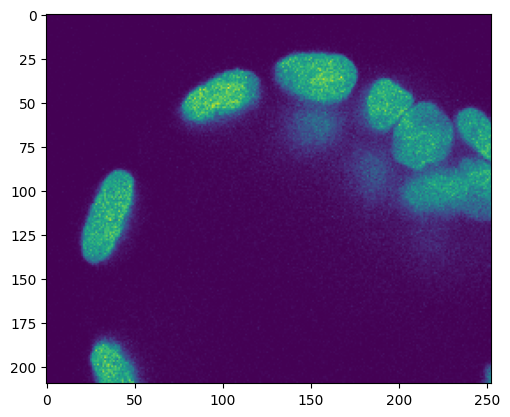

In [6]:
import matplotlib.pyplot as plt
plt.imshow(data)

Browse the z-section

In [7]:
from ipywidgets import *

def update(z=0):
    c = 1
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(img[z, c, :, :])
    plt.tight_layout()
    fig.canvas.flush_events()

interact(update, z= widgets.IntSlider(value=1, min=0, max=img.shape[0]-1, step=1, description="Select Z", continuous_update=False))

interactive(children=(IntSlider(value=1, continuous_update=False, description='Select Z', max=256), Output()),…

<function __main__.update(z=0)>

## Reading an image binary data from IDR using API
As mentioned previously, downloading and then working with a file assumes that you have a suitable reader installed locally. This might not always be possible or appropriate, depending on the image format. An image can be composed of multiple files on disk and thus downloading a single file might be insufficient.
You can nonetheless download binary data from IDR (and OMERO) using the Python API.

### Connect to IDR

In [8]:
### Install the libraries to connect to IDR

# Ice Python binding
%pip install https://github.com/glencoesoftware/zeroc-ice-py-linux-x86_64/releases/download/20240202/zeroc_ice-3.6.5-cp312-cp312-manylinux_2_28_x86_64.whl

# Package required to interact with IDR or OMERO you usually only need to install omero-py
%pip install omero-py

# Package to read the OMERO ROI
%pip install omero-cli-zarr


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.4/37.4 MB 53.4 MB/s eta 0:00:00


In [10]:

from omero.gateway import BlitzGateway
HOST = 'ws://idr.openmicroscopy.org/omero-ws'
conn = BlitzGateway('public', 'public',
                    host=HOST, secure=True)
print(conn.connect())
conn.c.enableKeepAlive(60)

True


In [11]:
image_id = 6001247

In [12]:
image = conn.getObject("Image", image_id)

Retrieve the information about the image.

In [13]:
pixels = image.getPrimaryPixels()
size_c = image.getSizeC()
size_x = image.getSizeX()
size_y = image.getSizeY()
size_t = image.getSizeT()
size_z = image.getSizeZ()
print(size_c)
# List Channels
for channel in image.getChannels():
    print('Channel:', channel.getLabel())

2
Channel: LaminB1
Channel: Dapi


Read the acquisition metadata.

In [14]:
import numpy
z, t = 100, 0 # set a timepoint and a Z-section
c_list = []
for c in range(size_c):  # all channels
    c_list.append((z, c, t))

    values = []
    # Load all the planes as YX numpy array
    planes = pixels.getPlanes(c_list)
    print("Downloading image %s" % image.getName())
    all_planes = numpy.stack(list(planes))
# Reshape to match what we have using the imageio
shape = (size_c, size_y, size_x)
data_reshaped = numpy.reshape(all_planes, newshape=shape)

In [15]:
print(data_reshaped.shape)

(2, 210, 253)


In [16]:
data_from_idr = data_reshaped[1, :, :]

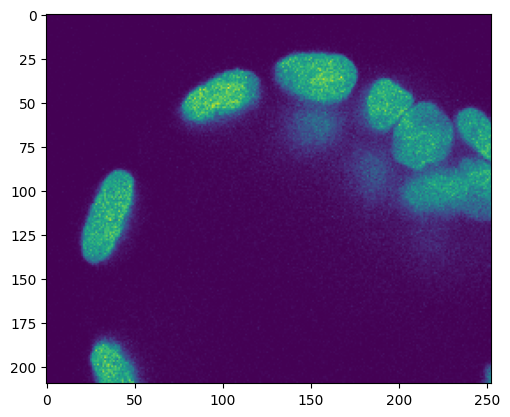

In [15]:
plt.imshow(data_from_idr)

**Exercise:**

* Write a ``for`` loop to load all the planes.
* Check the dimensions of the Numpy array.
* Reshape the array to ``size_t, size_c, size_z, size_y, size_x`` if it is not already available in that odrder.

## Load ROIs associated to an image

Region of Interest or ROIs usually resulting from analysis are saved independantly of the original binary data. ROIs can also be retrieved using the API. The supported elements are described in the [OME ROI model](https://ome-model.readthedocs.io/en/stable/developers/roi.html).

In [17]:
roi_service = conn.getRoiService()
result = roi_service.findByImage(image_id, None)

shapes = []
for roi in result.rois:
    shapes.append(roi.copyShapes())

ROIs associated with the image are masks in this case. In order to visualise them, we need to convert them to numpy array.

In [18]:
from omero_zarr import masks
dims = (size_t, size_c, size_z, size_y, size_x)
saver = masks.MaskSaver(None, image, numpy.int64)
labels, fillColors, properties = saver.masks_to_labels(shapes, mask_shape=dims)

Display the labels overlayed on top of the image.

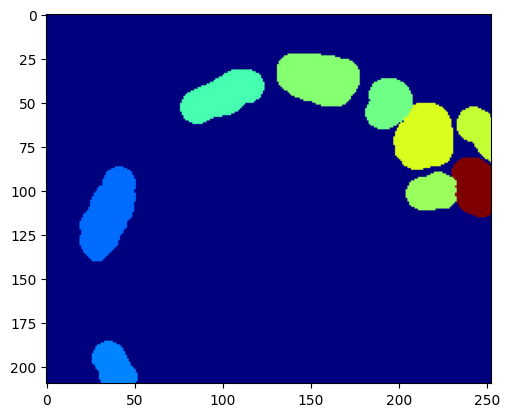

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
c = 1
t = 0
z = 100
img_labels = labels[t, c, z, :, :]
plt.imshow(data_reshaped[c, :, :])
plt.imshow(img_labels, cmap='jet', alpha=0.5*(img_labels>0))

### Disconnect from IDR

In [20]:
conn.close()

### License (BSD 2-Clause)¶

Copyright (C) 2026 BioImagingUK. All Rights Reserved.

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution. THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.